<a href="https://colab.research.google.com/github/adifatol/BIQA/blob/master/convNetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Utils

In [148]:
!ls blur

1600.BLUR.1.png		   log_seaside.BLUR.1.png
1600.BLUR.2.png		   log_seaside.BLUR.2.png
1600.BLUR.3.png		   log_seaside.BLUR.3.png
1600.BLUR.4.png		   log_seaside.BLUR.4.png
1600.BLUR.5.png		   log_seaside.BLUR.5.png
aerial_city.BLUR.1.png	   monument.BLUR.1.png
aerial_city.BLUR.2.png	   monument.BLUR.2.png
aerial_city.BLUR.3.png	   monument.BLUR.3.png
aerial_city.BLUR.4.png	   monument.BLUR.4.png
aerial_city.BLUR.5.png	   monument.BLUR.5.png
boston.BLUR.1.png	   native_american.BLUR.1.png
boston.BLUR.2.png	   native_american.BLUR.2.png
boston.BLUR.3.png	   native_american.BLUR.3.png
boston.BLUR.4.png	   native_american.BLUR.4.png
boston.BLUR.5.png	   native_american.BLUR.5.png
bridge.BLUR.1.png	   redwood.BLUR.1.png
bridge.BLUR.2.png	   redwood.BLUR.2.png
bridge.BLUR.3.png	   redwood.BLUR.3.png
bridge.BLUR.4.png	   redwood.BLUR.4.png
bridge.BLUR.5.png	   redwood.BLUR.5.png
butter_flower.BLUR.1.png   roping.BLUR.1.png
butter_flower.BLUR.2.png   roping.BLUR.2.png
butter_flower.BLUR.3.png 

# Upload Images

shows a dialog to upload new images

option to download the CSIQ Image Quality Database

In [0]:
# from google.colab import files

# uploaded = files.upload()

# for fn in uploaded.keys():
#   print('User uploaded file "{name}" with length {length} bytes'.format(
#       name=fn, length=len(uploaded[fn])))

In [150]:
import os

if not (
  os.path.exists("blur") and
  os.path.exists("contrast") and
  os.path.exists("jpeg") and
  os.path.exists("jpeg2000") and
  os.path.exists("fnoise")
):
  !wget http://vision.eng.shizuoka.ac.jp/csiq/src_imgs.zip
  !wget http://vision.eng.shizuoka.ac.jp/csiq/dst_imgs.zip

  !unzip -n src_imgs.zip
  !unzip -n dst_imgs.zip
else:
  print("images found, skipping.")

images found, skipping.


# Load Images in colab

loads images of a certain SHAPE into runtime memory

In [151]:

import os

# List Image Names
# Parses each file name of format <NAME>.png
# TODO: support for other extensions?
def image_list( ext = '.png'):
  names = {}
  for f in [file for file in os.listdir() if file.endswith(ext)]:
    fname = os.path.splitext(f)[0]
    names[fname] = 1
  return list(names.keys())

img_list = image_list()
print('Images found: ', img_list)

Images found:  ['roping', 'boston', 'woman', 'cactus', 'monument', 'swarm', 'lady_liberty', 'shroom', 'rushmore', 'sunset_sparrow', 'lake', 'redwood', 'fisher', 'trolley', 'veggies', 'snow_leaves', 'turtle', 'child_swimming', 'geckos', 'foxy', 'sunsetcolor', 'aerial_city', 'native_american', 'bridge', 'family', 'elk', '1600', 'butter_flower', 'couple', 'log_seaside']


In [152]:

# Load the images
# Encode them into jpg

DISTORT = ['blur','contrast','fnoise', 'jpeg', 'jpeg2000']
DISTORT_EXT = ['BLUR','contrast','fnoise', 'JPEG', 'jpeg2000']
Q_LEVELS = ['1','2','3','4','5']
NR_IMG = 'ALL' # 'ALL' 10, 20 ...

if NR_IMG == 'ALL':
  NR_IMG = len(img_list)

print(NR_IMG)

from random import randint
import numpy as np
import cv2

#TODO support for nItems = 'ALL'
#TODO support various loading order (randomize?)
def load_imgs(img_list, nItems):
  
  images = {}
  images['orig'] = []
  for dist in DISTORT:
    images[dist] = {}
    for qlvl in Q_LEVELS:
      images[dist][qlvl] = []

  for f in range(0,nItems):
    fname = img_list[f]
    original = fname+'.png'
    img_data = cv2.imread(original)
    img_data = cv2.cvtColor(img_data, cv2.COLOR_BGR2RGB)
    images['orig'].append(img_data)
    for dist, d_ext in zip(DISTORT, DISTORT_EXT):
      for qlvl in Q_LEVELS:
        f_path = dist+'/'+fname+'.'+d_ext+'.'+qlvl+'.png'
        img_data = cv2.imread(f_path)
        img_data = cv2.cvtColor(img_data, cv2.COLOR_BGR2RGB)
        images[dist][qlvl].append(img_data)
  return images

images = load_imgs(img_list, NR_IMG)

print("Nr of img:",len(images['orig']))


30
Nr of img: 30


In [0]:
from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator

def plot_all(arr_of_images, patch_estimator=False, columns = 5):
  spacing = 14.75
  minorLocator = MultipleLocator(spacing)
  fig = plt.figure(figsize=(20,10))
  for i, image in enumerate(arr_of_images):
    ax = fig.add_subplot(len(images) / columns + 1, columns, i + 1)
    if patch_estimator:
      ax.yaxis.set_minor_locator(minorLocator)
      ax.xaxis.set_minor_locator(minorLocator)
      ax.grid(which = 'minor')
    plt.imshow(image)
  plt.show()


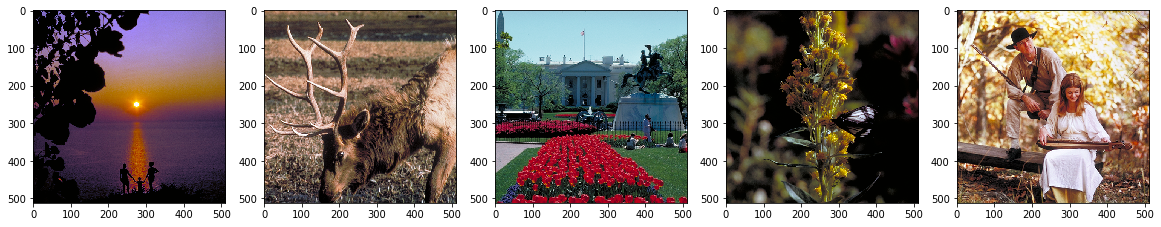

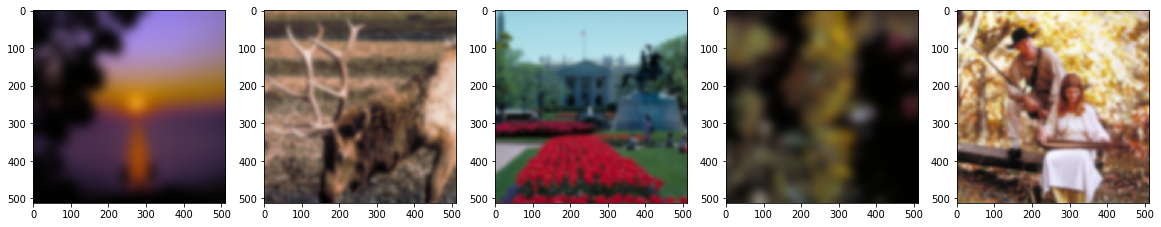

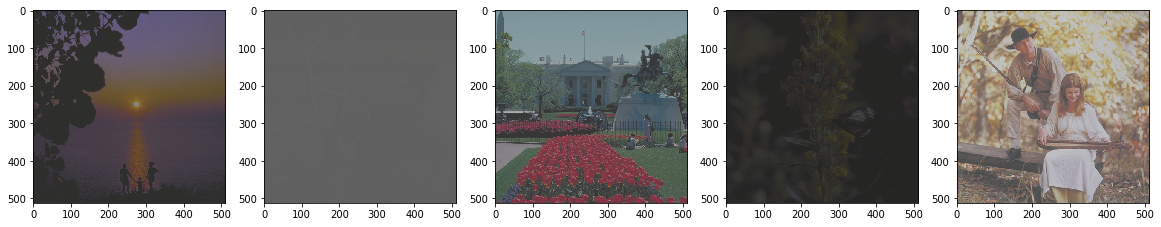

In [154]:
#Print some stats
max_to_show = min(NR_IMG,5)
rand_idx = randint(0, len(images['orig'])-max_to_show)
plot_all(images['orig'][rand_idx:rand_idx+max_to_show])
plot_all(images['blur']['5'][rand_idx:rand_idx+max_to_show])
plot_all(images['contrast']['5'][rand_idx:rand_idx+max_to_show])


# Score Images

apply the method suggested in [Learning without Human Scores for Blind Image Quality Assessment](https://www.cv-foundation.org/openaccess/content_cvpr_2013/papers/Xue_Learning_without_Human_2013_CVPR_paper.pdf)

## Extract Patches and calculate {SSIM} score

In [155]:
!pip install tqdm

In [156]:
#Calculate the number of patches


OWH = 512 # 512 x 512
WH = 14 #
WINDOW_SHAPE = (WH,WH,3)
PATCH_COUNT = int(int(OWH / WH) * int(OWH / WH))

print(PATCH_COUNT)

1296


In [157]:
from skimage.measure import compare_ssim
from skimage.util.shape import view_as_windows
from tqdm import tqdm

def plot_patches(patches):
  w=10
  h=10
  fig=plt.figure(figsize=(8, 8))
  columns = 1
  rows = 1
  for i in range(1, columns*rows +1):
      img = patches[i-1]
      fig.add_subplot(rows, columns, i)
      plt.imshow(img)
  plt.show()

def extract_patches(img):
  patches = np.squeeze(view_as_windows(img, WINDOW_SHAPE,step=WH))
  patches = np.reshape(patches,(-1,WH,WH,3))
  patches = np.sum(patches/3, axis=3, keepdims=True)
  return patches

dim_len, dim_dist, dim_q = len(images['orig']), len(DISTORT), len(Q_LEVELS);
test_len = dim_len

one_score = [[np.zeros(PATCH_COUNT) for x in range(dim_dist)] for y in range(dim_q)]
scores = [np.copy(one_score) for x in range(test_len)]
all_patches = []

for i in tqdm(range(len(images['orig'][:test_len]))):
  img = images['orig'][i]
  orig_patches = extract_patches(img)
  for idist, dist in enumerate(DISTORT):
    for iqlvl, qlvl in enumerate(Q_LEVELS):
      dist_img = images[dist][qlvl][i]
      distorted_patches = extract_patches(dist_img)
      local_scores = np.zeros(PATCH_COUNT)
      local_patches = []
      for j in range(PATCH_COUNT):
        orig_patch = orig_patches[j]
        dist_patch = distorted_patches[j]
        (score, diff) = compare_ssim(orig_patch, dist_patch, full=True, multichannel=True)
        local_scores[j] = (score + 1) / 2
        all_patches.append(dist_patch)
      scores[i][idist][iqlvl] = np.copy(local_scores)

#   plot_patches(orig_patches)
#   for patch in orig_patches:
#   (score, diff) = compare_ssim(dist_img, img, full=True, multichannel=True)
#   diff = (diff * 255).astype("uint8")
#   print("___")
#   print("SSIM: {}".format(score))


100%|██████████| 30/30 [05:00<00:00,  9.95s/it]


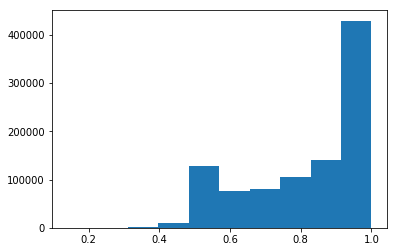

0.13880537900426232

In [158]:
plt.hist(np.array(scores).flatten())
plt.show()

min(np.array(scores).flatten())

## Calculate the C constant (![alt text](https://latex.codecogs.com/gif.latex?c%20%3D%20%5Cfrac%7B%5Csum%20_%7Bi%5Cepsilon%20%5COmega%7DS_%7Bi%7D%20%7D%7B10*%5Csum%20_%7Bi%5Cepsilon%20%5COmega_%7Bp%7D%7DS_%7Bi%7D%7D))

In [0]:
def the_C_constant(batch):
  all_sum = sum(batch)
  percentile = 30
  batch_percentile = np.percentile(batch,percentile)
  omega_p_sum = sum([i for i in batch if i <= batch_percentile])
  c = all_sum / (percentile * omega_p_sum)
  return c
# the_C_constant(scores[0][0][0])

## Histograms for scores

(30, 5, 5, 1296)
0.14665849062285755
comparing for 17
(img-17 dist-4 qual-3)


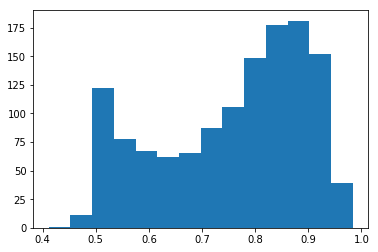

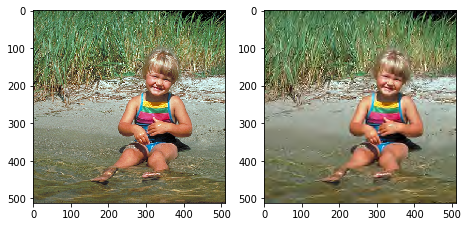

In [160]:
#Random scores visualisations

from mpl_toolkits.mplot3d import Axes3D

def histogram(img_idx, img_dist, img_qual):
  print("comparing for {}".format(img_idx))
  print("(img-{} dist-{} qual-{})".format(img_idx, img_dist, img_qual))
  plt.hist(scores[img_idx][img_dist][img_qual], bins='auto')
  plt.show()

ri = randint(0,dim_len-1)
rd = randint(0,dim_dist-1)
rq = randint(0,dim_q-1)

print(np.array(scores).shape)

for i in range(ri,ri+1):
  for d in range(rd,rd+1):
    for q in range(rq,rq+1):
      c = the_C_constant(scores[i][d][q])
      print(c)
      histogram(ri,rd,rq)
      plot_all([images['orig'][i],images[DISTORT[rd]][Q_LEVELS[rq]][ri]])


## Normalize scores

In [0]:
norm_scores = np.copy(scores)
for i in range(0,dim_len):
  for d in range(0,dim_dist):
    for q in range(0,dim_q):
      c = the_C_constant(scores[i][d][q])
      norm_scores[i][d][q][:] = [x / c for x in norm_scores[i][d][q]]
norm_scores = np.interp(norm_scores, (norm_scores.min(), norm_scores.max()), (0, +1))


(img-17 dist-jpeg2000 qual-4)


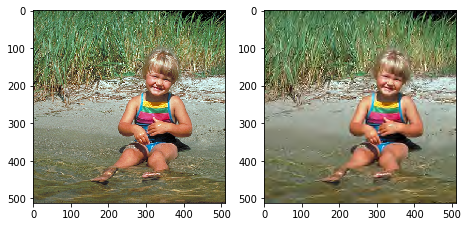

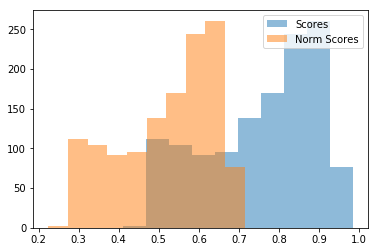

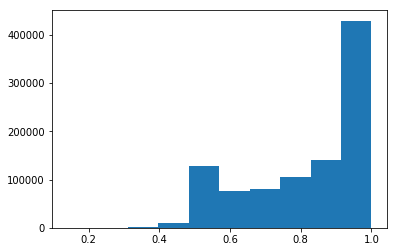

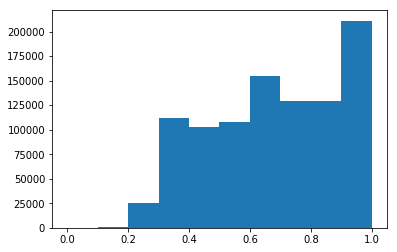

min scores 0.13880537900426232, min norm_scores 0.0, max scores 1.0, max norm_scores 1.0


In [162]:
print("(img-{} dist-{} qual-{})".format(ri, DISTORT[rd], Q_LEVELS[rq]))


plot_all([images['orig'][ri],images[DISTORT[rd]][Q_LEVELS[rq]][ri]])

plt.hist(scores[ri][rd][rq], alpha=0.5, label='Scores')
plt.hist(norm_scores[ri][rd][rq], alpha=0.5, label='Norm Scores')
plt.legend(loc='upper right')
plt.show()

plt.hist(np.array(scores).flatten())
plt.show()
plt.hist(np.array(norm_scores).flatten())
plt.show()

print("min scores {}, min norm_scores {}, max scores {}, max norm_scores {}".format(min(np.array(scores).flatten()), min(np.array(norm_scores).flatten()), max(np.array(scores).flatten()), max(np.array(norm_scores).flatten())))

## Score QAC - Quality Aware Clusters

[3, 4, 5, 6, 7, 8, 9, 10]
[0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
(30, 5, 5, 1296)
(5, 5, 1296)
(30, 5, 5, 1296)
{0.9, 1.0, 0.6, 0.8, 0.7, 0.5, 0.4, 0.3}


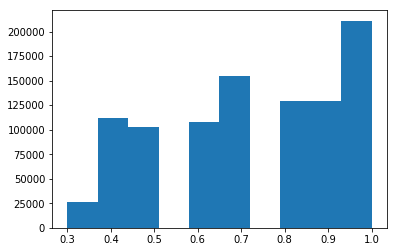

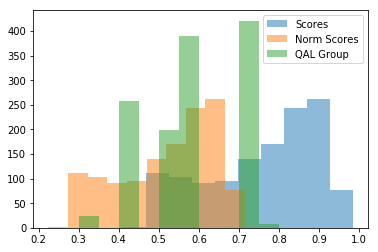

In [163]:
# Define The Score Levels used in QAC

L = 10 # The Score Levels used in QAC
SA = 3 # start class
Gl = list(range(SA,L+1))
print(Gl)
Gl[:] = [x / 10 for x in Gl]

one_group = [[np.zeros(PATCH_COUNT) for x in range(dim_dist)] for y in range(dim_q)]
G = [np.copy(one_group) for x in range(dim_len)]

classes = set([]) 

print(Gl)
print(np.array(G).shape)
print(np.array(one_group).shape)
print(np.array(norm_scores).shape)

for i in range(0,dim_len):
  for d in range(0,dim_dist):
    for q in range(0,dim_q):
# for i in range(ri,i+1):
#   for d in range(rd,rd+1):
#     for q in range(rq,rq+1):
      for p,score in enumerate(norm_scores[i][d][q]):
        G[i][d][q][p] = Gl[L-SA]
        for score_l in Gl:
          if score <= score_l:
            G[i][d][q][p] = score_l
            classes.add(score_l)
            break

print(classes)
            
plt.hist(np.array(G).flatten())
plt.show()

plt.hist(scores[ri][rd][rq], alpha=0.5, label='Scores')
plt.hist(norm_scores[ri][rd][rq], alpha=0.5, label='Norm Scores')
plt.hist(G[ri][rd][rq], alpha=0.5, label='QAL Group')
plt.legend(loc='upper right')
plt.show()

# Model Training (Keras)

## Extract Features (?)

## High pass filter - Difference of Gaussian (DoG) ( ![alt text]( https://latex.codecogs.com/gif.latex?h_%7B%5Csigma%20%7D%28r%29%3D1_%7Br%3D0%20%7D-%5Cfrac%7B1%7D%7B%5Csqrt%7B2%5Cpi%20%5Csigma%20%7D%7Dexp%28-%5Cfrac%7Br%5E%7B2%7D%7D%7B2%5Csigma%20%5E%7B2%7D%7D%29) )

In [0]:
from skimage import filters, color

def dog(patch, sigma):
  k = 1.6
  s1 = filters.gaussian(patch,k*sigma)
  s2 = filters.gaussian(patch,sigma)
  # multiply by sigma to get scale invariance
  dog = s1 - s2
  return dog

#Sigmas: [0.2, 2.0, 4.0]

def all_filtered_patches(all_patches, sigma):
  all_filtered = []
  for i in tqdm(range(len(all_patches))):
    patch = all_patches[i]
#     gray_patch = color.rgb2gray(patch)
    gray_patch = patch
    filtered = dog(gray_patch, sigma)
    all_filtered.append(filtered)
  return all_filtered

# fa = all_filtered_patches(all_patches, 0.5)
# fb = all_filtered_patches(all_patches, 2.0)
# fc = all_filtered_patches(all_patches, 4.0)

In [0]:

all_filtered = all_patches
# all_filtered = np.concatenate((fa, filtered_20, filtered_40),axis=2)
# print (np.array(all_filtered).shape)

## Split training / validation


train:
(826200, 14, 14, 1)
(826200,)

 y categorical:
(826200, 8)
(145800, 8)

validation:
(145800, 14, 14, 1)
(145800,)

Total:
(972000, 14, 14, 1)
(972000,)
Counter({1.0: 179415, 0.7: 131566, 0.9: 109806, 0.8: 109659, 0.4: 95438, 0.6: 91230, 0.5: 86989, 0.3: 22097})
Counter({1.0: 31590, 0.7: 23155, 0.9: 19617, 0.8: 19413, 0.4: 16583, 0.6: 16232, 0.5: 15464, 0.3: 3746})


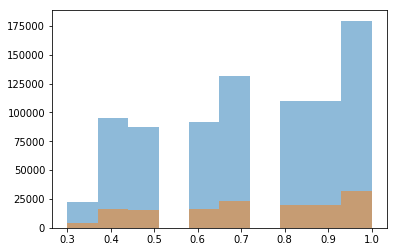

In [166]:
from sklearn.model_selection import train_test_split
from tensorflow import keras 

import collections

all_scores = np.array(G).flatten()

# Split the data
x_train, x_valid, y_train, y_valid = train_test_split(np.array(all_filtered), np.array(all_scores), test_size=0.15, shuffle= True)


num_classes = len(classes)

y_train_c = keras.utils.to_categorical(np.digitize(y_train, Gl)-1, num_classes)
y_valid_c = keras.utils.to_categorical(np.digitize(y_valid, Gl)-1, num_classes)

print("\ntrain:")
print(np.array(x_train).shape)
print(np.array(y_train).shape)

print("\n y categorical:")
print(np.array(y_train_c).shape)
print(np.array(y_valid_c).shape)

print("\nvalidation:")
print(np.array(x_valid).shape)
print(np.array(y_valid).shape)

print("\nTotal:")
print(np.array(all_patches).shape)
print(np.array(all_scores).shape)

counter=collections.Counter(y_train)
print(counter)

counter=collections.Counter(y_valid)
print(counter)

plt.hist(y_train, alpha=0.5)
plt.hist(y_valid, alpha=0.5)
plt.show()

Counter({(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0): 179415, (0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0): 131566, (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0): 109806, (0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0): 109659, (0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0): 95438, (0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0): 91230, (0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0): 86989, (1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0): 22097})


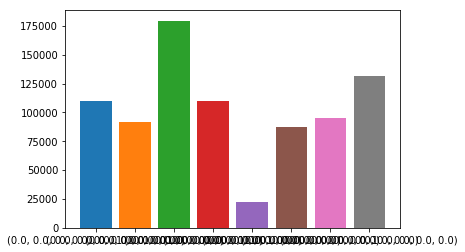

In [167]:
counter=collections.Counter([tuple(i) for i in y_train_c])
print(counter)

dic = dict(counter)
for key in dic.keys():
  plt.bar(str(key), dic[key])
plt.show()

## Declare the model

In [168]:
# The model, based on https://colab.research.google.com/github/tensorflow/tpu/blob/master/tools/colab/fashion_mnist.ipynb#scrollTo=Zo-Yk6LFGfSf
import keras
from keras import layers
from keras import optimizers

model = keras.Sequential()
model.add(layers.Convolution2D(16, (3, 3),
                        padding='same',
                        input_shape=x_train.shape[1:], activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Convolution2D(32, (3, 3), padding='same', activation= 'relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Convolution2D(64, (3, 3), padding='same', activation= 'relu'))
model.add(layers.MaxPooling2D(pool_size =(2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(num_classes, activation='softmax')) 
# Train model
# sgd = SGD(lr=0.005)
opt = optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 14, 14, 16)        160       
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 7, 7, 16)          0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 7, 7, 32)          4640      
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 3, 3, 32)          0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 3, 3, 64)          18496     
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 1, 1, 64)          0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 64)                0         
__________

## Train

In [169]:
#fit the model
fit_his = model.fit(x = x_train, y = y_train_c, validation_split=0.2, batch_size = 140, verbose=2, epochs=50)


Train on 660960 samples, validate on 165240 samples
Epoch 1/50
 - 42s - loss: 1.7821 - acc: 0.2936 - val_loss: 1.6710 - val_acc: 0.3224
Epoch 2/50
 - 42s - loss: 1.5931 - acc: 0.3485 - val_loss: 1.5410 - val_acc: 0.3617
Epoch 3/50
 - 42s - loss: 1.5175 - acc: 0.3734 - val_loss: 1.5727 - val_acc: 0.3598
Epoch 4/50
 - 42s - loss: 1.4793 - acc: 0.3857 - val_loss: 1.4990 - val_acc: 0.3787
Epoch 5/50
 - 42s - loss: 1.4570 - acc: 0.3945 - val_loss: 1.4498 - val_acc: 0.3934
Epoch 6/50
 - 42s - loss: 1.4361 - acc: 0.4018 - val_loss: 1.4310 - val_acc: 0.4020
Epoch 7/50
 - 42s - loss: 1.4223 - acc: 0.4065 - val_loss: 1.5059 - val_acc: 0.3879
Epoch 8/50
 - 42s - loss: 1.4077 - acc: 0.4120 - val_loss: 1.4003 - val_acc: 0.4139
Epoch 9/50
 - 42s - loss: 1.3962 - acc: 0.4156 - val_loss: 1.4433 - val_acc: 0.4012
Epoch 10/50
 - 42s - loss: 1.3873 - acc: 0.4186 - val_loss: 1.4050 - val_acc: 0.4109
Epoch 11/50
 - 42s - loss: 1.3812 - acc: 0.4219 - val_loss: 1.3996 - val_acc: 0.4150
Epoch 12/50
 - 42s - l

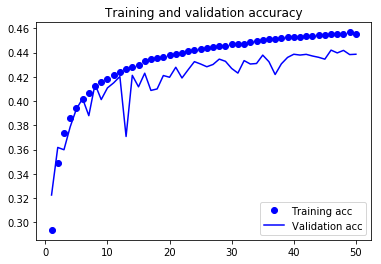

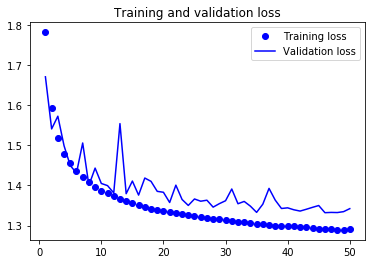

In [170]:
acc = fit_his.history['acc']
val_acc = fit_his.history['val_acc']
loss = fit_his.history['loss']
val_loss = fit_his.history['val_loss']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

## Validate

In [174]:
#evaluate on unseen data
score = model.evaluate(x_valid, y_valid_c, verbose=1)
print('Test accuarcy: {:0.2f}%'.format(score[1] * 100))

145800/145800 [==============================] - 12s 79us/step
Test accuarcy: 43.82%


277373
(14, 14, 1)
[[5.7234608e-02 4.0572658e-01 4.0756923e-01 7.4434191e-02 3.9566021e-02
  1.3731606e-02 1.7291685e-03 8.5365327e-06]]
2 0.40756923 2


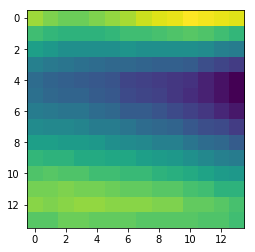

In [184]:
i = randint(0, x_train.shape[0]-1)
print(i)
mt = [[x_train[i]]]
pred = model.predict(mt)
plt.imshow(x_train[i].squeeze())
print(x_train[i].shape)
print(pred)
print(np.argmax(pred[0]), max(pred[0]), np.argmax(y_train_c[i]))


predicting for 94966 to 94998


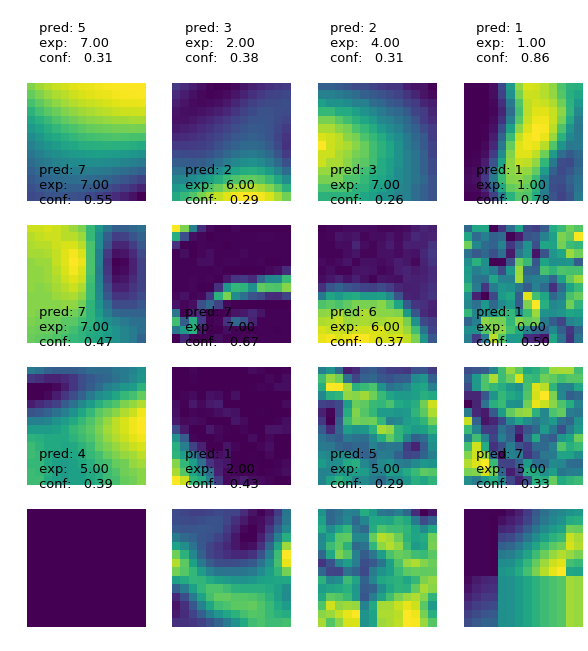

In [187]:
from matplotlib import pyplot
%matplotlib inline

def plot_predictions(images, predictions, y):
  n = images.shape[0]
  nc = int(np.ceil(n / 4))
  f, axes = pyplot.subplots(nc, 4)
  for i in range(nc * 4):
    yaxes = i // 4
    xaxes = i % 4
    axes[xaxes, yaxes].axis('off')

    pred = np.argmax(predictions[i])
    confidence = np.max(predictions[i])
    if i > n:
      continue
    axes[xaxes, yaxes].imshow(images[i])
    axes[xaxes, yaxes].text(0.5, 0.5, "\n pred: {0}\n exp: {1:6.2f}\n conf: {2:6.2f} \n\n".format(pred, np.argmax(y[i]), confidence) , fontsize=13)

  pyplot.gcf().set_size_inches(10, 10)

nr_ex = 32
start_from = randint(0, x_valid.shape[0]-nr_ex)
# start_from = 0
print("predicting for {} to {}".format(start_from, start_from+nr_ex))

# pred_y = model.predict(x_valid[start_from:start_from+nr_ex])

# max_pred = [np.argmax(y) for y in pred_y]
# print(max_pred)
# print(y_valid_oh[start_from:start_from+nr_ex])

plot_predictions(np.squeeze(x_valid[start_from:start_from+16]), model.predict(x_train[start_from:start_from+16]), y_train_c[start_from:start_from+16])

In [189]:
!pip install PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)  

model.save('biqa_model.h5')

# get the folder id where you want to save your file
file = drive.CreateFile({'parents':[{u'id': "1Iu9bS-fovG20py9_9A2-M7BJ56HG-sNB"}]})
file.SetContentFile('biqa_model.h5')
file.Upload()
print(file['id'])

     |████████████████████████████████| 993kB 6.5MB/s 
  Stored in directory: /root/.cache/pip/wheels/fa/d2/9a/d3b6b506c2da98289e5d417215ce34b696db856643bad779f4
Successfully built PyDrive


W0626 13:10:25.034403 140688864405376 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0 or google-auth
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import Lock

1iBhlQXD3Lr0EAV-pW0SNDx9VflBXZE6h


# Predict on images

In [0]:

def test_pred(to_predict):
  for pred_img in to_predict:
    pred_patches = extract_patches(pred_img)
    pred_scores = model.predict(pred_patches)

    #Build the image based on scores
    pred_args = []
    for p in pred_scores:
      pred_args.append(np.argmax(p))
    avg = np.mean(pred_args)
    print(avg)
#   plt.hist(pred_args)

Distortions: fnoise
6.271604938271605
6.150462962962963
5.575617283950617
4.823302469135802
3.993827160493827
3.64429012345679


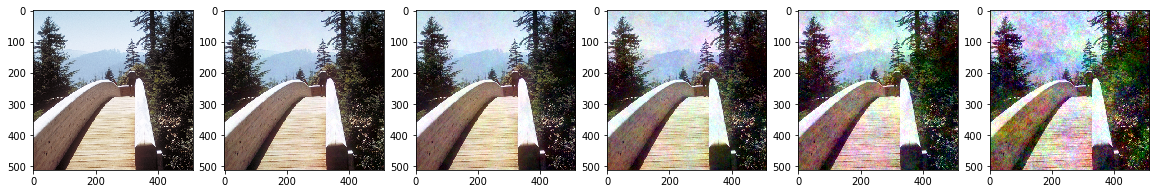

In [292]:
# Set 1

i = randint(0,NR_IMG-1)
d = randint(0, len(DISTORT)-1)
dist = DISTORT[d]
to_predict = [images['orig'][i], images[dist]['1'][i], images[dist]['2'][i], images[dist]['3'][i], images[dist]['4'][i], images[dist]['5'][i]]

print("Distortions: {}".format(dist))
test_pred(to_predict)
plot_all(to_predict, columns=6)

Distortions: jpeg
6.349537037037037
6.208333333333333
5.902777777777778
3.6550925925925926
2.662037037037037
1.816358024691358


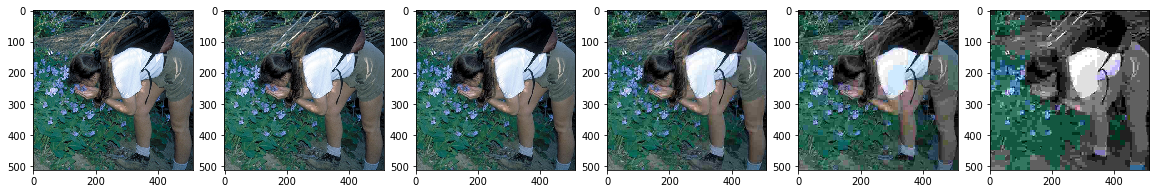

In [270]:
# Set 2

i = randint(0,NR_IMG-1)
d = randint(0, len(DISTORT)-1)
dist = DISTORT[d]
to_predict = [images['orig'][i], images[dist]['1'][i], images[dist]['2'][i], images[dist]['3'][i], images[dist]['4'][i], images[dist]['5'][i]]

print("Distortions: {}".format(dist))
test_pred(to_predict)
plot_all(to_predict, columns=6)

In [283]:
!wget https://www.invite-hotels.de/images/pictures/w7e1a130f291a00323bbb294ee1c23b0/w7e1b140b2b37001fbc1c9ab2e6af7cf/metropol_0516_07.jpg?w=512&h=512&r=3
!wget https://content3.jdmagicbox.com/comp/anantnag/w9/9999p1932.1932.130810120812.t2w9/catalogue/hotel-pine-spring-pahalgam-anantnag-4-star-hotels-hep1w99qty.jpg
!ls

--2019-06-26 14:15:46--  https://www.invite-hotels.de/images/pictures/w7e1a130f291a00323bbb294ee1c23b0/w7e1b140b2b37001fbc1c9ab2e6af7cf/metropol_0516_07.jpg?w=512
Resolving www.invite-hotels.de (www.invite-hotels.de)... 178.77.111.204, 2a01:488:42:1000:b24d:6fcc:c3:cee
Connecting to www.invite-hotels.de (www.invite-hotels.de)|178.77.111.204|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [image/jpeg]
Saving to: ‘metropol_0516_07.jpg?w=512.2’

metropol_0516_07.jp     [ <=>                ]  20.77K  --.-KB/s    in 0s      

2019-06-26 14:15:46 (152 MB/s) - ‘metropol_0516_07.jpg?w=512.2’ saved [21266]

--2019-06-26 14:15:48--  https://content3.jdmagicbox.com/comp/anantnag/w9/9999p1932.1932.130810120812.t2w9/catalogue/hotel-pine-spring-pahalgam-anantnag-4-star-hotels-hep1w99qty.jpg
Resolving content3.jdmagicbox.com (content3.jdmagicbox.com)... 173.223.30.128
Connecting to content3.jdmagicbox.com (content3.jdmagicbox.com)|173.223.30.128|:443... connecte

3.943287037037037
5.967592592592593


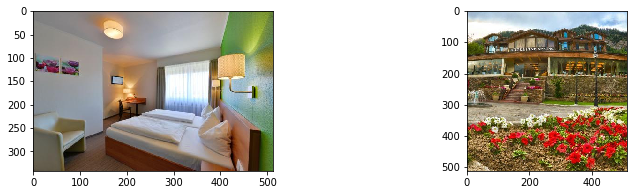

In [293]:
from_web = ['metropol_0516_07.jpg?w=512', 'hotel-pine-spring-pahalgam-anantnag-4-star-hotels-hep1w99qty.jpg']
images_from_web = []

for img_from_web in from_web:
  img_data = cv2.imread(img_from_web)
  img_data = cv2.cvtColor(img_data, cv2.COLOR_BGR2RGB)
  images_from_web.append(img_data)

test_pred(images_from_web)
plot_all(images_from_web, columns=3)